In [1]:
import pandas as pd
import sqlite3 as sl

In [2]:
#create database object
conn = sl.connect('NYT_covid.db')
c = conn.cursor()

In [3]:
#create table and populate
# deaths = pd.read_csv('Data-files/deaths.csv', index_col=0, encoding='latin-1')

# c.execute('DROP TABLE IF EXISTS deaths')
# c.execute('CREATE TABLE deaths (country str, placename str, frequency, start_date datetime, end_date datetime, year int, month int, week int, deaths int, expected_deaths int, excess_deaths int, baseline str)')
# conn.commit()

# deaths.to_sql('deaths',conn, if_exists='replace')

mask_use = pd.read_csv('Data-files/mask-use-by-county.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS mask_use')
c.execute('CREATE TABLE mask_use (countyfp str, never, rarely, sometimes, frequently, always)')
conn.commit()

mask_use.to_sql('mask_use',conn, if_exists='replace')

counties = pd.read_csv('Data-files/us-counties.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS counties')
c.execute('CREATE TABLE counties (date datetime, county str, state str, fips str, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

counties.to_sql('counties',conn, if_exists='replace')

states = pd.read_csv('Data-files/us-states.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS states')
c.execute('CREATE TABLE states (date datetime, state str, fips str, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

states.to_sql('states',conn, if_exists='replace')

us = pd.read_csv('Data-files/us.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS us')
c.execute('CREATE TABLE us (date datetime, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

us.to_sql('us',conn, if_exists='replace')

In [4]:
#Confirm that tables necessary are present

res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

deaths
mask_use
counties
states
us


In [5]:
deaths = pd.read_sql('''select * from deaths limit 10;''',conn)
deaths

,country,placename,frequency,start_date,end_date,year,month,week,deaths,expected_deaths,excess_deaths,baseline
0,Austria,None,weekly,2020-01-06,2020-01-12,2020,1,2.0,1702,1814.0,-112.0,2015-2019 historical data
1,Austria,None,weekly,2020-01-13,2020-01-19,2020,1,3.0,1797,1824.0,-27.0,2015-2019 historical data
2,Austria,None,weekly,2020-01-20,2020-01-26,2020,1,4.0,1778,1832.0,-54.0,2015-2019 historical data
3,Austria,None,weekly,2020-01-27,2020-02-02,2020,2,5.0,1947,1836.0,111.0,2015-2019 historical data
4,Austria,None,weekly,2020-02-03,2020-02-09,2020,2,6.0,1678,1835.0,-157.0,2015-2019 historical data
5,Austria,None,weekly,2020-02-10,2020-02-16,2020,2,7.0,1721,1826.0,-105.0,2015-2019 historical data
6,Austria,None,weekly,2020-02-17,2020-02-23,2020,2,8.0,1715,1809.0,-94.0,2015-2019 historical data
7,Austria,None,weekly,2020-02-24,2020-03-01,2020,3,9.0,1768,1784.0,-16.0,2015-2019 historical data
8,Austria,None,weekly,2020-03-02,2020-03-08,2020,3,10.0,1744,1754.0,-10.0,2015-2019 historical data
9,Austria,None,weekly,2020-03-09,2020-03-15,2020,3,11.0,1718,1719.0,-1.0,2015-2019 historical data


In [6]:
mask = pd.read_sql('''SELECT * FROM MASK_USE LIMIT 10;''',conn)
mask

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
5,1011,0.031,0.040,0.144,0.286,0.500
6,1013,0.102,0.053,0.257,0.137,0.451
7,1015,0.152,0.108,0.130,0.167,0.442
8,1017,0.117,0.037,0.150,0.136,0.560
9,1019,0.135,0.027,0.161,0.158,0.520


In [7]:
county = pd.read_sql('''SELECT * FROM counties LIMIT 10;''',conn)
county

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0
5,2020-01-25,Orange,California,6059.0,1,0
6,2020-01-25,Cook,Illinois,17031.0,1,0
7,2020-01-25,Snohomish,Washington,53061.0,1,0
8,2020-01-26,Maricopa,Arizona,4013.0,1,0
9,2020-01-26,Los Angeles,California,6037.0,1,0


In [8]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12.0,8.0]

In [9]:
# join county data with mask use survey data

df = pd.read_sql('''SELECT c.date, state, county, cases, deaths,
                           m.never as pct_never_mask,
                           m.rarely as pct_rarely_mask,
                           m.sometimes as pct_sometimes_mask,
                           m.frequently as pct_frequently_mask,
                           m.always as pct_always_mask
                    FROM counties c 
                    JOIN mask_use m on c.fips = m.countyfp
                    WHERE c.state = 'Illinois'
                    ORDER BY c.date desc''',conn)

df

,date,state,county,cases,deaths,pct_never_mask,pct_rarely_mask,pct_sometimes_mask,pct_frequently_mask,pct_always_mask
0,2020-09-08,Illinois,Woodford,331,4,0.062,0.067,0.112,0.242,0.517
1,2020-09-08,Illinois,Winnebago,4572,152,0.031,0.030,0.089,0.193,0.657
2,2020-09-08,Illinois,Williamson,1065,20,0.095,0.122,0.136,0.183,0.464
3,2020-09-08,Illinois,Will,12415,361,0.041,0.024,0.062,0.134,0.739
4,2020-09-08,Illinois,Whiteside,612,19,0.025,0.066,0.042,0.218,0.649
...,...,...,...,...,...,...,...,...,...,...
16406,2020-01-28,Illinois,Cook,1,0,0.023,0.021,0.072,0.162,0.722
16407,2020-01-27,Illinois,Cook,1,0,0.023,0.021,0.072,0.162,0.722
16408,2020-01-26,Illinois,Cook,1,0,0.023,0.021,0.072,0.162,0.722
16409,2020-01-25,Illinois,Cook,1,0,0.023,0.021,0.072,0.162,0.722


In [10]:
df.isnull().sum()

date                   0
state                  0
county                 0
cases                  0
deaths                 0
pct_never_mask         0
pct_rarely_mask        0
pct_sometimes_mask     0
pct_frequently_mask    0
pct_always_mask        0
dtype: int64

In [11]:
df.dtypes

date                    object
state                   object
county                  object
cases                    int64
deaths                   int64
pct_never_mask         float64
pct_rarely_mask        float64
pct_sometimes_mask     float64
pct_frequently_mask    float64
pct_always_mask        float64
dtype: object

In [12]:
df.date = pd.to_datetime(df['date'])
df.head()

,date,state,county,cases,deaths,pct_never_mask,pct_rarely_mask,pct_sometimes_mask,pct_frequently_mask,pct_always_mask
0,2020-09-08,Illinois,Woodford,331,4,0.062,0.067,0.112,0.242,0.517
1,2020-09-08,Illinois,Winnebago,4572,152,0.031,0.030,0.089,0.193,0.657
2,2020-09-08,Illinois,Williamson,1065,20,0.095,0.122,0.136,0.183,0.464
3,2020-09-08,Illinois,Will,12415,361,0.041,0.024,0.062,0.134,0.739
4,2020-09-08,Illinois,Whiteside,612,19,0.025,0.066,0.042,0.218,0.649


In [13]:
df.dtypes

date                   datetime64[ns]
state                          object
county                         object
cases                           int64
deaths                          int64
pct_never_mask                float64
pct_rarely_mask               float64
pct_sometimes_mask            float64
pct_frequently_mask           float64
pct_always_mask               float64
dtype: object

In [14]:
df = df.set_index('date')
df

,state,county,cases,deaths,pct_never_mask,pct_rarely_mask,pct_sometimes_mask,pct_frequently_mask,pct_always_mask
date,,,,,,,,,
2020-09-08,Illinois,Woodford,331,4,0.062,0.067,0.112,0.242,0.517
2020-09-08,Illinois,Winnebago,4572,152,0.031,0.030,0.089,0.193,0.657
2020-09-08,Illinois,Williamson,1065,20,0.095,0.122,0.136,0.183,0.464
2020-09-08,Illinois,Will,12415,361,0.041,0.024,0.062,0.134,0.739
2020-09-08,Illinois,Whiteside,612,19,0.025,0.066,0.042,0.218,0.649
...,...,...,...,...,...,...,...,...,...
2020-01-28,Illinois,Cook,1,0,0.023,0.021,0.072,0.162,0.722
2020-01-27,Illinois,Cook,1,0,0.023,0.021,0.072,0.162,0.722
2020-01-26,Illinois,Cook,1,0,0.023,0.021,0.072,0.162,0.722


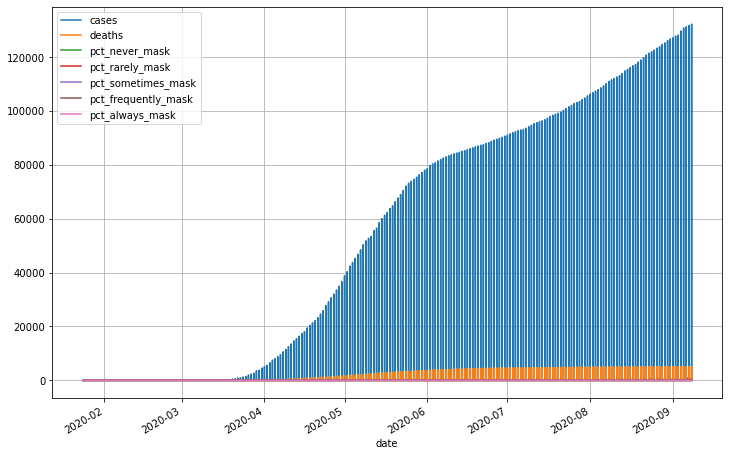

In [15]:
df.plot(grid=True)

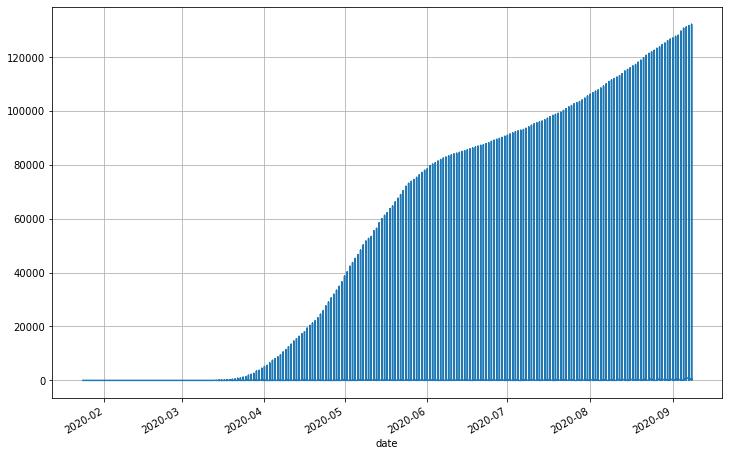

In [16]:
df.cases.plot(grid=True)

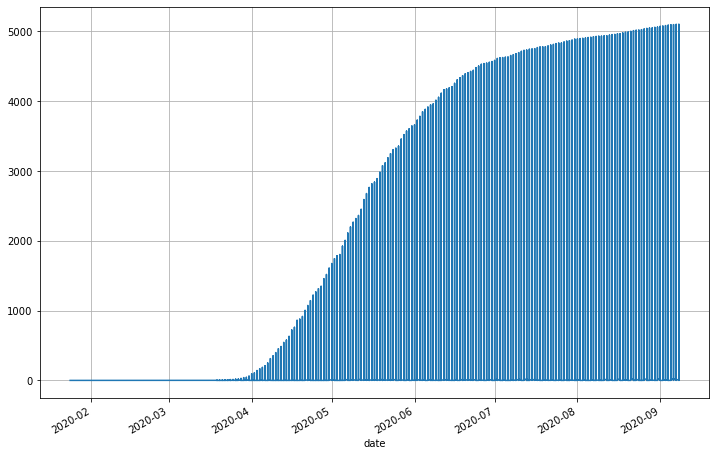

In [17]:
df.deaths.plot(grid=True)

In [19]:
df.pct_always_mask.value_counts

<bound method IndexOpsMixin.value_counts of date
2020-09-08    0.517
2020-09-08    0.657
2020-09-08    0.464
2020-09-08    0.739
2020-09-08    0.649
              ...  
2020-01-28    0.722
2020-01-27    0.722
2020-01-26    0.722
2020-01-25    0.722
2020-01-24    0.722
Name: pct_always_mask, Length: 16411, dtype: float64>

In [20]:
def data_summary(df):
    eda_df= {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['max'] = df.max()
    eda_df['min'] = df.min()
    
    return pd.DataFrame(eda_df)

data_summary(df)

,null_sum,dtypes,count,mean,median,max,min
cases,0,int64,16411,1280.475657,46.000,132079,1
county,0,object,16411,NaN,NaN,Woodford,Adams
deaths,0,int64,16411,53.618366,1.000,5098,0
pct_always_mask,0,float64,16411,0.516901,0.522,0.788,0.212
pct_frequently_mask,0,float64,16411,0.218606,0.211,0.391,0.126
pct_never_mask,0,float64,16411,0.069908,0.059,0.238,0
pct_rarely_mask,0,float64,16411,0.070118,0.062,0.196,0.006
pct_sometimes_mask,0,float64,16411,0.124487,0.112,0.311,0.034
state,0,object,16411,NaN,NaN,Illinois,Illinois


In [21]:
# all states, not just IL 
us = pd.read_sql('''SELECT c.date, state, county, cases, deaths,
                           m.never as pct_never_mask,
                           m.rarely as pct_rarely_mask,
                           m.sometimes as pct_sometimes_mask,
                           m.frequently as pct_frequently_mask,
                           m.always as pct_always_mask
                    FROM counties c 
                    JOIN mask_use m on c.fips = m.countyfp
                    ORDER BY c.date desc''',conn)

us

,date,state,county,cases,deaths,pct_never_mask,pct_rarely_mask,pct_sometimes_mask,pct_frequently_mask,pct_always_mask
0,2020-09-08,Wyoming,Weston,19,0,0.142,0.129,0.148,0.207,0.374
1,2020-09-08,Wyoming,Washakie,110,6,0.204,0.155,0.069,0.285,0.287
2,2020-09-08,Wyoming,Uinta,309,2,0.098,0.278,0.154,0.207,0.264
3,2020-09-08,Wyoming,Teton,450,1,0.095,0.157,0.160,0.247,0.340
4,2020-09-08,Wyoming,Sweetwater,314,2,0.061,0.295,0.230,0.146,0.268
...,...,...,...,...,...,...,...,...,...,...
499651,2020-01-24,Washington,Snohomish,1,0,0.017,0.014,0.056,0.191,0.721
499652,2020-01-24,Illinois,Cook,1,0,0.023,0.021,0.072,0.162,0.722
499653,2020-01-23,Washington,Snohomish,1,0,0.017,0.014,0.056,0.191,0.721
499654,2020-01-22,Washington,Snohomish,1,0,0.017,0.014,0.056,0.191,0.721


In [25]:
us.date = pd.to_datetime(us['date'])
us = us.set_index('date')
us.head()

,state,county,cases,deaths,pct_never_mask,pct_rarely_mask,pct_sometimes_mask,pct_frequently_mask,pct_always_mask
date,,,,,,,,,
2020-09-08,Wyoming,Weston,19,0,0.142,0.129,0.148,0.207,0.374
2020-09-08,Wyoming,Washakie,110,6,0.204,0.155,0.069,0.285,0.287
2020-09-08,Wyoming,Uinta,309,2,0.098,0.278,0.154,0.207,0.264
2020-09-08,Wyoming,Teton,450,1,0.095,0.157,0.160,0.247,0.340
2020-09-08,Wyoming,Sweetwater,314,2,0.061,0.295,0.230,0.146,0.268


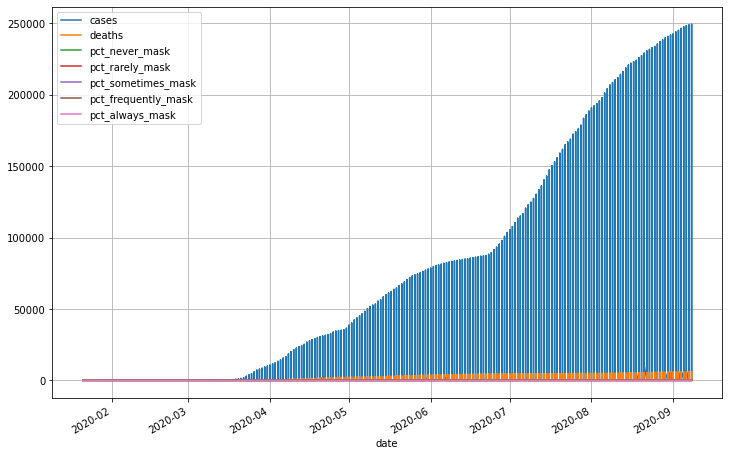

In [26]:
us.plot(grid=True)

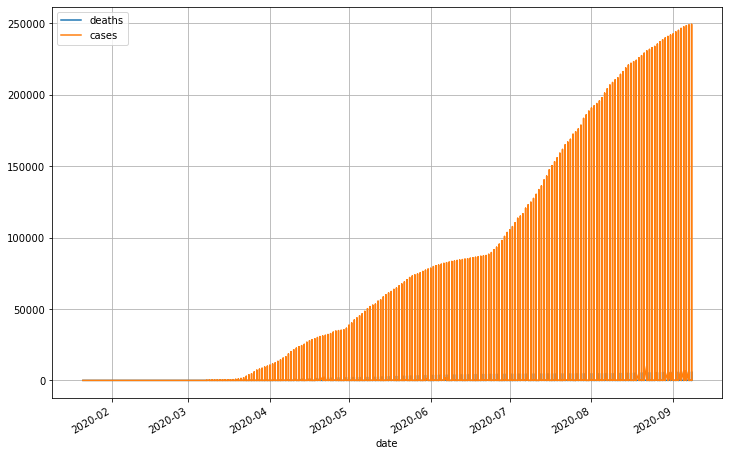

In [27]:
us[['deaths','cases']].plot(grid=True)

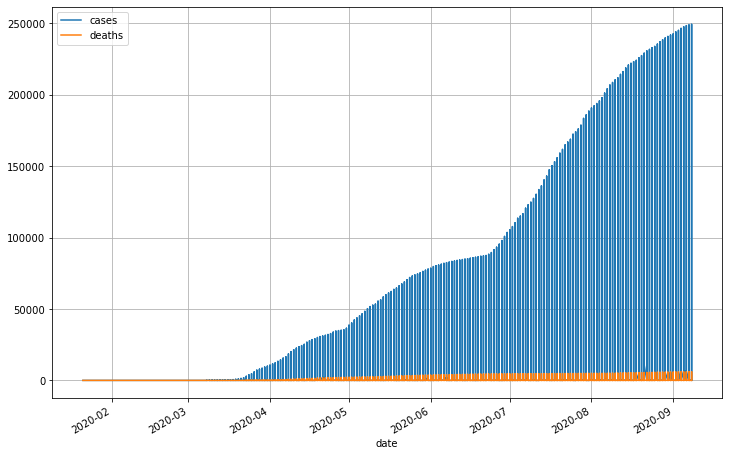

In [28]:
us[['cases','deaths']].plot(grid=True)

In [29]:
data_summary(us)

,null_sum,dtypes,count,mean,median,max,min
cases,0,int64,499656,846.880053,67.000,249241,1
county,0,object,499656,NaN,NaN,Ziebach,Abbeville
deaths,0,int64,499656,29.918150,1.000,6036,0
pct_always_mask,0,float64,499656,0.516377,0.505,0.889,0.115
pct_frequently_mask,0,float64,499656,0.206262,0.203,0.549,0.029
pct_never_mask,0,float64,499656,0.077349,0.066,0.432,0
pct_rarely_mask,0,float64,499656,0.080513,0.072,0.384,0
pct_sometimes_mask,0,float64,499656,0.119490,0.113,0.422,0.001
state,0,object,499656,NaN,NaN,Wyoming,Alabama
